In [10]:
!mkdir -p /kaggle/working/grammar_scoring
print("Created project directory")

Created project directory


In [11]:
!pip install SpeechRecognition librosa language-tool-python spacy nltk -q
print("Installed required libraries")

Installed required libraries


In [12]:
%%writefile /kaggle/working/grammar_scoring/requirements.txt
numpy>=1.20.0
pandas>=1.3.0
matplotlib>=3.4.0
seaborn>=0.11.0
librosa>=0.8.1
SpeechRecognition>=3.8.1
nltk>=3.6.0
spacy>=3.1.0
whisper>=1.0.0
torch>=1.9.0
language-tool-python>=2.7.1
tqdm>=4.62.0
ipython>=7.0.0

Writing /kaggle/working/grammar_scoring/requirements.txt


In [13]:
%%writefile /kaggle/working/grammar_scoring/install.py
import subprocess
import sys
import os

def check_kaggle():
    return os.path.exists('/kaggle/input')

def install_dependencies():
    print("Installing dependencies...")
    
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
    except Exception as e:
        print(f"Error installing main requirements: {e}")
    
    import nltk
    print("Downloading NLTK resources...")
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    

    print("Downloading spaCy model...")
    try:
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    except Exception as e:
        print(f"Error downloading spaCy model: {e}")
        if check_kaggle():
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl"])
            except Exception as e2:
                print(f"Error with alternative spaCy install: {e2}")

def setup_environment():
    """Set up the complete environment"""
    print("Setting up Grammar Scoring Engine environment...")
    
    install_dependencies()
    
    if check_kaggle():
        print("Running on Kaggle - environment setup complete")
    else:
        print("Not running on Kaggle - environment setup complete")
    
    print("\nAll set! You can now run the Grammar Scoring Engine.")

if __name__ == "__main__":
    setup_environment()

Writing /kaggle/working/grammar_scoring/install.py


In [14]:
%%writefile /kaggle/working/grammar_scoring/audio_processing.py
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

def load_audio(file_path):
    try:
        waveform, sample_rate = librosa.load(file_path, sr=None)
        return waveform, sample_rate
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None, None

def display_audio(file_path):
    waveform, sample_rate = load_audio(file_path)
    if waveform is None:
        return
        
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Audio Waveform')
    plt.tight_layout()
    plt.show()
    
    try:
        ipd.display(ipd.Audio(file_path))
    except Exception as e:
        print(f"Error playing audio: {e}")

def extract_audio_features(file_path):
    waveform, sample_rate = load_audio(file_path)
    if waveform is None:
        return {}
        
    features = {}
    
    features['duration'] = librosa.get_duration(y=waveform, sr=sample_rate)
    
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=waveform, sr=sample_rate)[0])
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=waveform, sr=sample_rate)[0])
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=waveform, sr=sample_rate)[0])
    
    tempo, _ = librosa.beat.beat_track(y=waveform, sr=sample_rate)
    features['tempo'] = tempo
    
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    for i, mfcc in enumerate(mfccs):
        features[f'mfcc_{i}'] = np.mean(mfcc)
    
    return features

def process_audio_dataset(audio_files):
   
    results = []
    
    for file_path in tqdm(audio_files, desc="Processing audio files"):
        features = extract_audio_features(file_path)
        if features:
            features['audio_path'] = file_path
            results.append(features)
    
    return pd.DataFrame(results)

Writing /kaggle/working/grammar_scoring/audio_processing.py


In [15]:
%%writefile /kaggle/working/grammar_scoring/transcription.py
import speech_recognition as sr
import pandas as pd
from tqdm.notebook import tqdm
import os

def transcribe_audio(audio_path):

    recognizer = sr.Recognizer()
    
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
            return text
    except Exception as e:
        print(f"Error transcribing audio {os.path.basename(audio_path)}: {e}")
        return None

def transcribe_audio_whisper(audio_path):
    
    try:
        import whisper
        model = whisper.load_model("base")
        result = model.transcribe(audio_path)
        return result["text"]
    except Exception as e:
        print(f"Error transcribing with whisper: {e}")
        return None

def process_audio_files(df, audio_column='audio_path', transcribe=True, use_whisper=False):
    
    results = df.copy()
    
    if 'transcription' not in results.columns:
        results['transcription'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Transcribing audio"):
        audio_path = row[audio_column]
        
        if pd.notna(results.at[idx, 'transcription']) and not transcribe:
            continue
            
        if use_whisper:
            transcription = transcribe_audio_whisper(audio_path)
        else:
            transcription = transcribe_audio(audio_path)
            
        if transcription:
            results.at[idx, 'transcription'] = transcription
    
    transcribed_count = results['transcription'].notna().sum()
    print(f"Successfully transcribed {transcribed_count} of {len(results)} audio files")
    
    return results

Writing /kaggle/working/grammar_scoring/transcription.py


In [16]:
%%writefile /kaggle/working/grammar_scoring/grammar_analysis.py
import language_tool_python
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import pandas as pd
from tqdm.notebook import tqdm

try:
    tool = language_tool_python.LanguageTool('en-US')
except:
    tool = None
    print("Warning: LanguageTool could not be initialized. Grammar checking may be limited.")

try:
    nlp = spacy.load("en_core_web_sm")
except:
    nlp = None
    print("Warning: spaCy model could not be loaded.")

def analyze_grammar(text):
    
    if not text or not tool:
        return {
            'text': text or '',
            'error_count': 0,
            'errors': [],
            'error_categories': {},
            'error_rate': 0
        }
    
    matches = tool.check(text)
    
    word_count = len(word_tokenize(text))
    
    error_categories = {}
    for match in matches:
        category = match.category
        if category in error_categories:
            error_categories[category] += 1
        else:
            error_categories[category] = 1
    
    return {
        'text': text,
        'error_count': len(matches),
        'errors': matches,
        'error_categories': error_categories,
        'error_rate': len(matches) / max(word_count, 1)  
    }

def get_grammar_features(text):
    
    if not text:
        return {}
    
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)
    avg_sentence_length = word_count / max(sentence_count, 1)
    
    pos_tags = nltk.pos_tag(words)
    pos_counts = {}
    for _, tag in pos_tags:
        if tag in pos_counts:
            pos_counts[tag] += 1
        else:
            pos_counts[tag] = 1
    
    pos_ratios = {f'{pos}_ratio': count / max(word_count, 1) for pos, count in pos_counts.items()}
    
    grammar_analysis = analyze_grammar(text)
    error_rate = grammar_analysis['error_rate']
    
    features = {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'error_rate': error_rate,
        'error_count': grammar_analysis['error_count']
    }
    
    features.update(pos_ratios)
    
    if nlp and text:
        try:
            doc = nlp(text)
            
            dep_counts = {}
            for token in doc:
                if token.dep_ in dep_counts:
                    dep_counts[token.dep_] += 1
                else:
                    dep_counts[token.dep_] = 1
            
            dep_ratios = {f'{dep}_ratio': count / max(word_count, 1) 
                          for dep, count in dep_counts.items()}
            
            features.update(dep_ratios)
            
            features['noun_chunk_count'] = len(list(doc.noun_chunks))
            features['noun_chunk_ratio'] = features['noun_chunk_count'] / max(word_count, 1)
            
        except Exception as e:
            print(f"Error extracting spaCy features: {e}")
    
    return features

def analyze_transcriptions(df, text_column='transcription'):
    
    results = df.copy()
    
    results['error_count'] = 0
    results['error_rate'] = 0
    
    all_features = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing grammar"):
        transcription = row[text_column]
        
        if pd.isna(transcription) or not transcription:
            all_features.append({})
            continue
        
        grammar_analysis = analyze_grammar(transcription)
        
        results.at[idx, 'error_count'] = grammar_analysis['error_count']
        results.at[idx, 'error_rate'] = grammar_analysis['error_rate']
        
        features = get_grammar_features(transcription)
        all_features.append(features)
    
    features_df = pd.DataFrame(all_features)
    
    for col in features_df.columns:
        if col not in results.columns:
            results[col] = features_df[col]
    
    return results

Writing /kaggle/working/grammar_scoring/grammar_analysis.py


In [17]:
%%writefile /kaggle/working/grammar_scoring/scoring.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rule_based_score(error_rate, word_count=None):
    score = 100 - (error_rate * 100)
    
    if word_count and word_count < 10:
        confidence_factor = word_count / 10
        score = 50 + (score - 50) * confidence_factor
    
    return max(0, min(100, score))  # Clamp to 0-100

def train_scoring_model(df, target_column='grammar_score'):
    
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found in dataframe")
        return None, None
    
    exclude_cols = ['audio_path', 'transcription', target_column, 'errors', 'error_categories']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    data = df.dropna(subset=feature_cols + [target_column])
    
    if len(data) < 10:
        print(f"Warning: Only {len(data)} valid samples for training. More data recommended.")
        return None, None
    
    X = data[feature_cols]
    y = data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"Model RMSE: {rmse:.2f}")
    print(f"Score range: {min(y):.1f} to {max(y):.1f}")
    
    importances = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return model, importances

def score_samples(df, model=None):
    
    results = df.copy()
    
    if model:
        exclude_cols = ['audio_path', 'transcription', 'grammar_score', 'errors', 'error_categories']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        
        scoring_data = df[feature_cols].fillna(0)
        
        results['grammar_score'] = model.predict(scoring_data)
    else:
        results['grammar_score'] = df.apply(
            lambda row: rule_based_score(
                row['error_rate'], 
                row['word_count'] if 'word_count' in df.columns else None
            ), 
            axis=1
        )
    
    return results

Writing /kaggle/working/grammar_scoring/scoring.py


In [18]:
%%writefile /kaggle/working/grammar_scoring/visualization.py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_results(df):
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(df['grammar_score'].dropna(), kde=True, bins=20)
    plt.title('Distribution of Grammar Scores')
    plt.xlabel('Score (0-100)')
    
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='error_rate', y='grammar_score', data=df)
    plt.title('Error Rate vs Grammar Score')
    plt.xlabel('Errors per Word')
    plt.ylabel('Grammar Score')
    
    if 'word_count' in df.columns:
        plt.subplot(2, 2, 3)
        sns.scatterplot(x='word_count', y='grammar_score', data=df)
        plt.title('Word Count vs Grammar Score')
        plt.xlabel('Word Count')
        plt.ylabel('Grammar Score')
    
        plt.subplot(2, 2, 4)
        sns.scatterplot(x='word_count', y='error_count', data=df)
        plt.title('Word Count vs Error Count')
        plt.xlabel('Word Count')
        plt.ylabel('Error Count')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances):
    
    plt.figure(figsize=(12, 8))
    top_features = importances.head(15)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Important Features for Grammar Scoring')
    plt.tight_layout()
    plt.show()

def generate_error_analysis(df):
    
    if 'error_categories' not in df.columns:
        print("No error categories available for analysis")
        return
    
    error_cats = {}
    for idx, row in df.iterrows():
        if pd.isna(row['error_categories']):
            continue
            
        for cat, count in row['error_categories'].items():
            if cat in error_cats:
                error_cats[cat] += count
            else:
                error_cats[cat] = count
    
    error_df = pd.DataFrame({'category': list(error_cats.keys()), 
                             'count': list(error_cats.values())})
    error_df = error_df.sort_values('count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='category', data=error_df.head(10))
    plt.title('Top 10 Grammar Error Categories')
    plt.tight_layout()
    plt.show()

def create_sample_report(result):
    
    if not result or not isinstance(result, dict):
        print("No valid result to display")
        return
    
    print("\n===== Grammar Analysis Report =====")
    print(f"Transcription: {result.get('transcription', 'N/A')}")
    print(f"Grammar Score: {result.get('grammar_score', 0):.2f}/100")
    print(f"Error Count: {result.get('error_count', 0)}")
    
    if 'errors' in result and result['errors']:
        print("\nGrammar Errors:")
        print(result['errors'])
        
    if 'features' in result and result['features']:
        print("\nText Features:")
        features = result['features']
        for key in ['word_count', 'sentence_count', 'avg_sentence_length']:
            if key in features:
                print(f"- {key}: {features[key]:.2f}")
                
    print("\n" + "="*35)

Writing /kaggle/working/grammar_scoring/visualization.py


In [19]:
%%writefile /kaggle/working/grammar_scoring/main.py
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

# Import our modules
from utils import setup_kaggle_environment, load_dataset, get_kaggle_dataset_path, list_audio_files_in_dataset
from audio_processing import load_audio, display_audio, extract_audio_features, process_audio_dataset
from transcription import transcribe_audio, process_audio_files
from grammar_analysis import analyze_grammar, analyze_transcriptions
from scoring import rule_based_score, train_scoring_model, score_samples
from visualization import visualize_results, plot_feature_importance, generate_error_analysis, create_sample_report

def analyze_single_sample(audio_path, use_whisper=False):
    
    print(f"Analyzing audio file: {os.path.basename(audio_path)}")
    display_audio(audio_path)
    
    audio_features = extract_audio_features(audio_path)
    
    if use_whisper:
        from transcription import transcribe_audio_whisper
        transcription = transcribe_audio_whisper(audio_path)
    else:
        transcription = transcribe_audio(audio_path)
    
    if not transcription:
        return {"error": "Could not transcribe audio"}
    
    print(f"Transcription: {transcription}")
    
    grammar_analysis = analyze_grammar(transcription)
    
    error_text = ""
    for error in grammar_analysis['errors']:
        error_text += f"- {error.message} (at position {error.offset})\n"
    
    score = rule_based_score(grammar_analysis['error_rate'])
    
    result = {
        'audio_path': audio_path,
        'transcription': transcription,
        'grammar_score': score,
        'error_count': grammar_analysis['error_count'],
        'error_rate': grammar_analysis['error_rate'],
        'errors': error_text,
        'features': extract_audio_features(audio_path)
    }
    
    return result

def complete_grammar_scoring_workflow(dataset_name=None, audio_file=None, use_whisper=False):
    
    setup_kaggle_environment()
    
    if audio_file:
        result = analyze_single_sample(audio_file, use_whisper)
        create_sample_report(result)
        return result
        
    elif dataset_name:
        print(f"Processing dataset: {dataset_name}")
        
        audio_files = list_audio_files_in_dataset(dataset_name)
        
        if not audio_files:
            print("No audio files found in dataset")
            return None
            
        print("Extracting audio features...")
        audio_df = process_audio_dataset(audio_files)
        
        print("Transcribing audio...")
        transcribed_df = process_audio_files(audio_df, use_whisper=use_whisper)
        
        print("Analyzing grammar...")
        grammar_df = analyze_transcriptions(transcribed_df)
        
        print("Scoring samples...")
        scored_df = score_samples(grammar_df)
        
        print("Generating visualizations...")
        visualize_results(scored_df)
        
        output_path = '/kaggle/working/grammar_scores.csv'
        scored_df.to_csv(output_path, index=False)
        print(f"Results saved to: {output_path}")
        
        return scored_df
        
    else:
        print("Please provide either a dataset_name or audio_file")
        return None

def kaggle_interactive_demo():
    
    print("===== Grammar Scoring Engine for Voice Samples =====")
    print("This tool analyzes spoken language for grammatical correctness.")
    
    print("\nAvailable datasets in this Kaggle session:")
    for dirname, _, _ in os.walk('/kaggle/input'):
        if dirname != '/kaggle/input':
            print(f"- {dirname.replace('/kaggle/input/', '')}")
    
    dataset_name = input("\nEnter dataset name (e.g., 'username/dataset-name') or press Enter to process a single file: ")
    
    if dataset_name:
        use_whisper = input("Use Whisper for transcription? (better quality but slower) [y/N]: ").lower() == 'y'
        results_df = complete_grammar_scoring_workflow(dataset_name=dataset_name, use_whisper=use_whisper)
        
    else:
        print("\nTo analyze a single file, upload it or use a file from a dataset.")
        file_path = input("Enter path to audio file: ")
        
        if os.path.exists(file_path):
            use_whisper = input("Use Whisper for transcription? (better quality but slower) [y/N]: ").lower() == 'y'
            result = complete_grammar_scoring_workflow(audio_file=file_path, use_whisper=use_whisper)
        else:
            print(f"File not found: {file_path}")

# Main execution
if __name__ == "__main__":
    kaggle_interactive_demo()

Writing /kaggle/working/grammar_scoring/main.py


In [20]:
%run /kaggle/working/grammar_scoring/install.py

Setting up Grammar Scoring Engine environment...
Installing dependencies...
Error installing main requirements: Command '['/usr/bin/python3', '-m', 'pip', 'install', '-r', 'requirements.txt']' returned non-zero exit status 1.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Running on Kaggle - environment setup complete

All set! You can now run the Grammar Scoring Engine.


In [21]:
%%writefile /kaggle/working/grammar_scoring/utils.py

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys

def setup_kaggle_environment():
    """Configure environment for Kaggle."""
    if os.path.exists('/kaggle/input'):
        print("Running on Kaggle")
        # List available datasets
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
    else:
        print("Not running on Kaggle")
    
    try:
        import nltk
        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')
        
        try:
            import language_tool_python
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "language-tool-python"])
            
        try:
            import speech_recognition
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "SpeechRecognition"])
            
        try:
            import spacy
            try:
                nlp = spacy.load("en_core_web_sm")
            except:
                subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
            subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
            
    except Exception as e:
        print(f"Error setting up environment: {e}")

def load_dataset(data_path):
    """
    Load dataset containing audio file paths and optional transcriptions.
    Expected format: CSV with columns 'audio_path' and optionally 'transcription' and 'grammar_score'
    """
    df = pd.read_csv(data_path)
    return df

def get_kaggle_dataset_path(dataset_name, file_path):
    """
    Construct the full path to a file in a Kaggle dataset.
    """
    base_path = '/kaggle/input'
    return os.path.join(base_path, dataset_name, file_path)

def list_audio_files_in_dataset(dataset_name, extension='.wav'):
    """List all audio files in a Kaggle dataset with a specific extension."""
    files = []
    base_path = f'/kaggle/input/{dataset_name}'
    
    if not os.path.exists(base_path):
        print(f"Dataset path {base_path} not found")
        return files
        
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            if filename.endswith(extension):
                files.append(os.path.join(dirname, filename))
    
    print(f"Found {len(files)} {extension} files in {dataset_name}")
    return files

Writing /kaggle/working/grammar_scoring/utils.py


In [22]:
import sys
sys.path.append('/kaggle/working/grammar_scoring')

from main import complete_grammar_scoring_workflow, kaggle_interactive_demo

In [25]:
# Install Whisper and its dependencies
!pip install openai-whisper
!pip install torch
print("Whisper installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 21.7 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 4.4 MB/s eta 0:00:00:00:0100:01m
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803405 sha256=b9c9c5145b96c8917a82454bd71597293dee50b9e8911bb844fd1a711ac094d6
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper
Whisper installed successfully!


Running on Kaggle
/kaggle/input/okokokok/WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.wav
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Analyzing audio file: WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.wav


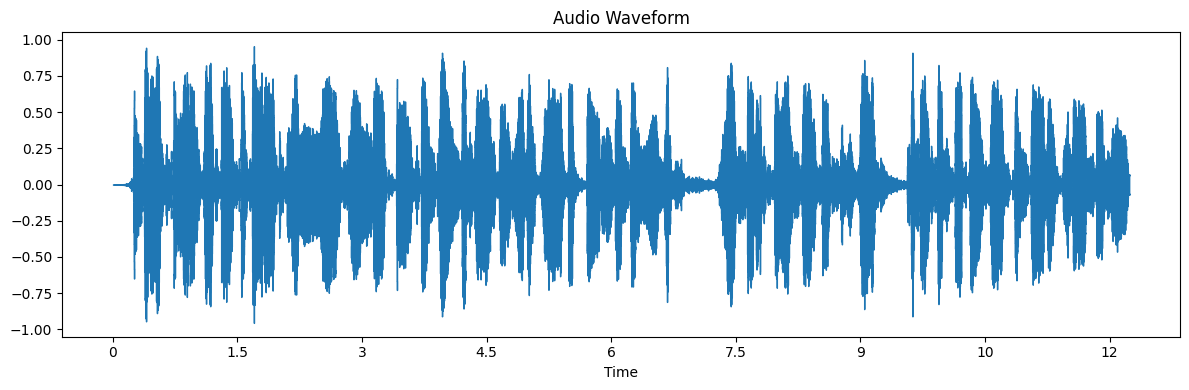

100%|███████████████████████████████████████| 139M/139M [00:05<00:00, 28.9MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Transcription:  They are coming to the party tonight and me and my friends is going to dance and having a lot of fun But the music have been stored by the DJs because some people was complaining about the noise

===== Grammar Analysis Report =====
Transcription:  They are coming to the party tonight and me and my friends is going to dance and having a lot of fun But the music have been stored by the DJs because some people was complaining about the noise
Grammar Score: 97.44/100
Error Count: 1

Grammar Errors:
- “music” is a singular noun. It appears that the verb form is incorrect. (at position 116)


Text Features:



In [26]:
from main import complete_grammar_scoring_workflow

result = complete_grammar_scoring_workflow(
    audio_file="/kaggle/input/okokokokok/WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.wav",
    use_whisper=True  
)

Converting WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.mp3 to WAV format...
Successfully converted to /kaggle/working/converted_audio.wav

Analyzing the converted audio file with Whisper...
Running on Kaggle
/kaggle/input/okokokokok/WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.wav
/kaggle/input/okokokokok/WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.mp3
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Analyzing audio file: converted_audio.wav


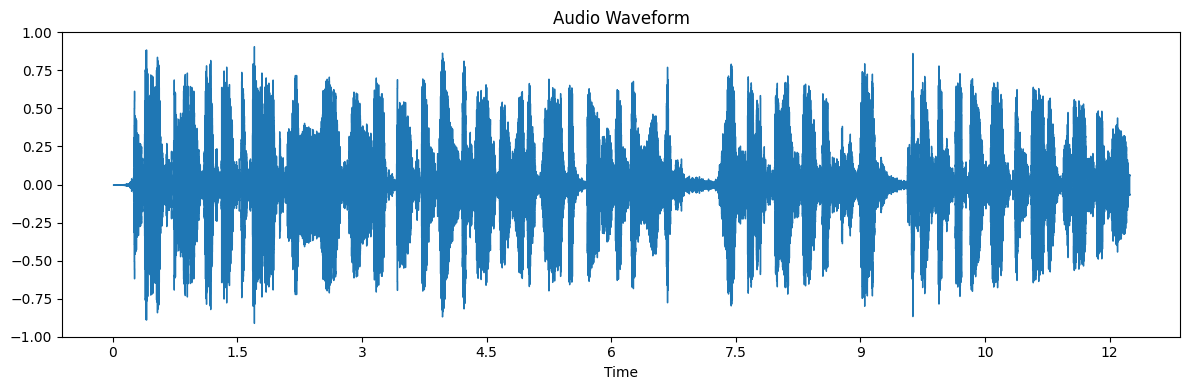

/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

Transcription:  They are coming to the party tonight and me and my friends is going to dance and having a lot of fun But the music have been stored by the DJs because some people was complaining about the noise

===== Grammar Analysis Report =====
Transcription:  They are coming to the party tonight and me and my friends is going to dance and having a lot of fun But the music have been stored by the DJs because some people was complaining about the noise
Grammar Score: 97.44/100
Error Count: 1

Grammar Errors:
- “music” is a singular noun. It appears that the verb form is incorrect. (at position 116)


Text Features:



In [28]:
#This command for MP3 File (this will convert MP3 to WAV format)
import librosa
import soundfile as sf
import os
from main import complete_grammar_scoring_workflow

input_file = "/kaggle/input/okokokokok/WhatsApp Audio 2025-04-06 at 17.15.33_a9983236.waptt.mp3"  

print(f"Converting {os.path.basename(input_file)} to WAV format...")
try:
    y, sr = librosa.load(input_file, sr=None)
    
    output_file = "/kaggle/working/converted_audio.wav"
    sf.write(output_file, y, sr)
    print(f"Successfully converted to {output_file}")
    
    print("\nAnalyzing the converted audio file with Whisper...")
    result = complete_grammar_scoring_workflow(
        audio_file=output_file,
        use_whisper=True  
    )
    
except Exception as e:
    print(f"Error processing audio: {e}")